In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import *    
import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.Models
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import r2_score
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from scipy import stats
from sklearn import linear_model

In [10]:
#Import your data
#DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [4]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']

In [5]:
#Get your response dataset
response_number = 1
response = [col for col in DF if col.startswith(predictors[response_number])]
response.append("patientID")
response_df = DF[response]

In [6]:
y = response_df.values
y = response_df.drop(['patientID'], axis = 1).values
y = StandardScaler().fit_transform(y)

In [7]:
groups = response_df['patientID']

In [8]:
#X_m = [albums[0], albums[1], albums[2], albums[3], albums[4], albums[5], albums[6]]
#del X_m[response_number]
#X_m = np.array(X_m, dtype = float)

In [9]:
predictors.append(tuple(predictors))

In [ ]:
#Select number of runs
nruns = 50
folds = 10
n_datasets = 8

#Using one omics at a time
prediction_train_f = []
observed_train_f = []
prediction_test_f = []
observed_test_f = []

for predictor_number in tqdm(range(n_datasets)):
    
    #Get your predictor dataset
    predictor = [col for col in DF if col.startswith(predictors[predictor_number])]
    predictor_df = DF[predictor]
    X = predictor_df.values
    X = StandardScaler().fit_transform(X)

    #prediction_train, observed_train, 
    prediction_train, observed_train, prediction_test, observed_test = zip(*Parallel(n_jobs=nruns)
                           (delayed(butterfly.Models.RF)
                            (X, y, groups, folds, 'daisy_chain') 
                            for cv in range(nruns)))
                
    prediction_train_f.append(prediction_train)
    observed_train_f.append(observed_train)
    prediction_test_f.append(prediction_test)
    observed_test_f.append(observed_test)

  0%|          | 0/8 [00:00<?, ?it/s]

In [96]:
#Create a stacked model from the RFs
stacked_RF = []

for r in range(nruns):
    
    ST_prediction_train = []
    ST_prediction_test = []

    for k in range(n_datasets):
        ST_prediction_train.append(pd.Series(prediction_train_f[k][0].values.ravel('F')))
        ST_prediction_test.append(pd.Series(prediction_test_f[k][0].values.ravel('F')))

    ST_prediction_train = np.transpose(pd.DataFrame(ST_prediction_train))
    ST_observed_train = pd.Series(observed_train_f[0][0].values.ravel('F'))
    ST_prediction_test = np.transpose(pd.DataFrame(ST_prediction_test))
    ST_observed_test = pd.Series(observed_test_f[0][0].values.ravel('F'))
    
    #RF
    STK_RF = RandomForestRegressor(n_estimators=100,
                               min_samples_split = 5,
                               random_state=0)

    STK_RF.fit(ST_prediction_train, ST_observed_train)
    
    STK_RF_prediction_train = STK_RF.predict(ST_prediction_train)
    STK_RF_prediction_train_r = stats.spearmanr(STK_RF_prediction_train, ST_observed_train)
    STK_RF_prediction_test = STK_RF.predict(ST_prediction_test)
    STK_RF_prediction_test_r = stats.spearmanr(STK_RF_prediction_test, ST_observed_test)
    
    stacked_RF.append(STK_RF_prediction_train_r, STK_RF_prediction_test_r)
    
    #Lasso
    clf = linear_model.Lasso(alpha=0.1, ,normalize=False, max_iter=1e5)
    clf.fit(ST_prediction_train, ST_observed_train)
    
    STK_LS_prediction_train = clf.predict(ST_prediction_train)
    STK_LS_prediction_train_r = stats.spearmanr(STK_LS_prediction_train, ST_observed_train)
    STK_LS_prediction_test = clf.predict(ST_prediction_test)
    STK_LS_prediction_test_r = stats.spearmanr(STK_LS_prediction_test, ST_observed_test)
    
    stacked_LS.append(STK_LS_prediction_train_r, STK_LS_prediction_test_r)


In [ ]:
statistic = 'spearman'

In [23]:
each_omic_train = []
each_omic_test = []

for omic in range(2):    
    each_feature_train = []
    each_run_train = []
    
    each_feature_test = []
    each_run_test = []

    for runs in range(nruns):
        correl_train = prediction_train_f[omic][runs].corrwith(observed_train_f[omic][runs], axis = 0, method = statistic) 
        each_feature_train.append(correl_train)
        each_run_train.append(np.mean(each_feature_train))
        
        correl_test = prediction_test_f[omic][runs].corrwith(observed_test_f[omic][runs], axis = 0, method = statistic) 
        each_feature_test.append(correl_test)
        each_run_test.append(np.mean(each_feature_test))

    each_omic_train.append(np.mean(each_run_train))
    each_omic_test.append(np.mean(each_run_test))

In [35]:
each_omic_train = []
each_omic_test = []

for omic in range(2):    
    each_feature_train = []
    each_run_train = []
    
    each_feature_test = []
    each_run_test = []

    for runs in range(nruns):
        correl_train = prediction_train_f[omic][runs].corrwith(observed_train_f[omic][runs], axis = 0, method = statistic) 
        each_feature_train.append(correl_train)
        each_run_train.append(np.mean(each_feature_train))
        
        correl_test = prediction_test_f[omic][runs].corrwith(observed_test_f[omic][runs], axis = 0, method = statistic) 
        each_feature_test.append(correl_test)
        each_run_test.append(np.mean(each_feature_test))

    each_omic_train.append(np.mean(each_run_train))
    each_omic_test.append(np.mean(each_run_test))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

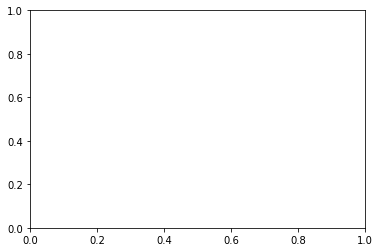

In [36]:
#Plot the results
plt.bar(y_pos, each_omic_test, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 
                                      'cyan', 'salmon', 'slategray'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
plt.show()

In [18]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s', 'all']
y_pos = np.arange(len(predictors))

In [19]:
#Plot the results
plt.bar(y_pos, each_omic_train, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 
                                      'cyan', 'salmon', 'slategray', 'magenta'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
plt.show()

NameError: name 'each_omic_train' is not defined